## 1. Loading the data

In [75]:
from dataset import SubjectTrialDataset_SingleElectrode
from subject_braintreebank import BrainTreebankSubject
from subject_ajile12 import AjileSubject
import torch
from model_model import BFModule
from model_transformers import Transformer
import torch.nn as nn
from train_utils import log
import random

AJILE = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
log(f'Using device: {device}')
dtype = torch.bfloat16

subject_id, trial_id = (3, 4) if AJILE else (3, 0)
window_size = 512 if AJILE else 2048
subject = AjileSubject(subject_id, cache=True) if AJILE else BrainTreebankSubject(subject_id, cache=True)
electrode_subset = ["10GRID"] if AJILE else [ 'F3d1',
 'F3d2',
 'F3d3',
 'F3d4',
 'F3d5',
 'F3d6',
 'F3d7',
 'F3d8',
 'F3d9',
 'F3d10',]
eval_electrode_index = 0 if AJILE else 4
subject.set_electrode_subset(electrode_subset)
dataset = SubjectTrialDataset_SingleElectrode(subject, trial_id, window_size=window_size, dtype=dtype, unsqueeze_electrode_dimension=False, electrodes_subset=electrode_subset)
log("Data shape: " + str(dataset[0]['data'].shape))

[20:45:30 gpu 7.7G ram 3.5G] (0) Using device: cuda
[20:45:34 gpu 7.7G ram 4.0G] (0) Data shape: torch.Size([2048])


## 2. Defining the modules
### Distribution Inverter

In [78]:
class DistributionInverter(BFModule):
    def __init__(self, samples, eps=1e-5):
        super().__init__()
        self.samples = samples
        self.mean = nn.Parameter(samples.mean(dim=0).view(1, 1, -1))
        self.std = nn.Parameter(samples.std(dim=0).view(1, 1, -1))
        self.eps = eps

    def forward(self, x):
        # x is of shape (batch_size, seq_len, n_channels)
        # samples is of shape (n_samples, n_channels)
        return (x - self.mean) / (self.std + self.eps)
        # return torch.sum(self.samples.unsqueeze(0).unsqueeze(0) <= x.unsqueeze(-1), dim=-1) / len(self.samples)

In [83]:
# Create samples from 10 random indices of the dataset
samples = torch.cat([dataset[random.randint(0, len(dataset)-1)]['data'].flatten() for _ in range(100)])
inverter = DistributionInverter(samples=samples).to(device, dtype=dtype)

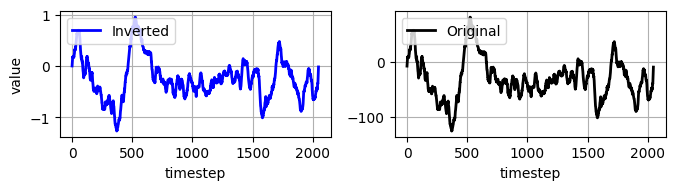

In [85]:
import matplotlib.pyplot as plt

# Get the data
example_idx = 1000
inverted_data = inverter(dataset[example_idx]['data'].unsqueeze(0).to(device, dtype=dtype)).detach().cpu().float().numpy().flatten()
original_data = dataset[example_idx]['data'].unsqueeze(0).detach().cpu().float().numpy().flatten()

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 2))

# Plot inverted data on first axis
ax1.plot(inverted_data, color='blue', linewidth=2, label='Inverted')
ax1.set_xlabel('timestep')
ax1.set_ylabel('value') 
ax1.grid(True)
ax1.legend(loc='upper left')

# Plot original data on second axis
ax2.plot(original_data, color='k', linewidth=2, label='Original')
ax2.set_xlabel('timestep')
ax2.grid(True)
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

### Masker

In [49]:
class Masker(BFModule):
    def __init__(self, p_masked_intervals, interval_length=1):
        super().__init__()
        self.p_masked_intervals = p_masked_intervals
        self.interval_length = interval_length
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, channels)
        batch_size, seq_len, channels = x.shape
        
        # Initialize mask tensor with all True values
        mask = torch.zeros((seq_len, channels), dtype=torch.bool, device=x.device)
        masked_x = x.clone()

        n_total_intervals = seq_len * channels
        n_masked_intervals = int(n_total_intervals * self.p_masked_intervals)

        # Create a flattened list of all possible (time, channel) indices
        all_indices = [(t, c) for t in range(seq_len-self.interval_length) for c in range(channels)]
        # Randomly select indices to mask
        masked_indices = random.sample(all_indices, n_masked_intervals)
        # Create the mask and apply it to x
        for t, c in masked_indices:
            # For each selected index, mask an interval of length self.interval_length
            mask[t:t+self.interval_length, c] = True
            masked_x[..., t:t+self.interval_length, c] = 0.0  # Replace with zeros
        
        return masked_x, mask

class NoneMasker(BFModule):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x, None


### FFTaker

In [50]:
class FFTaker(BFModule):
    def __init__(self, n_fft, hop_length):
        super().__init__()
        self.n_fft = n_fft
        self.hop_length = hop_length
        
    def forward(self, x):
        # x is of shape (batch_size, seq_len, n_channels)
        # output is of shape (batch_size, n_fft//2 + 1, n_channels)
        return torch.stft(x, n_fft=self.n_fft, hop_length=self.hop_length, return_complex=True)
        

### Embedder

In [51]:
class EmbedderInterpolation(BFModule):
    def __init__(self, d_model, resolution=10, range=(-3, 3)):
        super().__init__()
        self.d_model = d_model
        self.resolution = resolution
        self.range = range
        self.delta = (range[1] - range[0]) / (resolution-1)

        self.embedding_centers = torch.linspace(range[0], range[1], resolution)
        self.embedding_weights = torch.nn.Parameter(torch.randn(resolution, d_model) / d_model)
        
    def forward(self, x):
        # x is of shape (batch_size, seq_len, n_channels, d_input)
        # output is of shape (batch_size, seq_len, n_channels, d_model)
        batch_size, seq_len, n_channels, d_input = x.shape
        assert d_input == 1, "d_input must be 1, EmbedderInterpolation only supports single input channel"
        x = x.squeeze(-1)

        output = torch.zeros(*x.shape, self.d_model, device=x.device, dtype=x.dtype)
        for center_i, embedding_center in enumerate(self.embedding_centers):
            distance_multiplier = torch.maximum(1 - torch.abs(x - embedding_center) / self.delta, torch.tensor(0))
            output += distance_multiplier.unsqueeze(-1) * self.embedding_weights[center_i].view(1, 1, 1, -1)
        output[x<self.range[0]] = self.embedding_weights[0]
        output[x>self.range[1]] = self.embedding_weights[-1]
        return output

# class EmbedderDiscretized(BFModule):
#     def __init__(self, d_model, resolution=10, range=(-3, 3)):
#         super().__init__()
#         self.d_model = d_model
#         self.resolution = resolution
#         self.range = range
        
#     def forward(self, x):
#         # x is of shape (batch_size, seq_len, n_channels)
#         # output is of shape (batch_size, seq_len, n_channels, d_model)
#         output = torch.zeros(*x.shape, self.d_model, device=x.device, dtype=x.dtype)
#         for center_i, embedding_center in enumerate(self.embedding_centers):
#             distance_multiplier = torch.maximum(1 - torch.abs(x - embedding_center) / self.delta, torch.tensor(0))
#             output += distance_multiplier.unsqueeze(-1) * self.embedding_weights[center_i].view(1, 1, 1, -1)

class EmbedderLinear(BFModule):
    def __init__(self, d_model, d_input):
        super().__init__()
        self.d_model = d_model
        self.d_input = d_input
        self.linear_embedding = nn.Linear(d_input, d_model)

    def forward(self, x):
        return self.linear_embedding(x)

from hilbert_decode import hilbert_decode
class EmbedderHilbert(BFModule):
    def __init__(self, d_model, d_hilbert=4, d_input=1, resolution=6, range=None):
        super().__init__()
        self.d_model = d_model
        self.d_hilbert = d_hilbert
        self.d_input = d_input
        self.linear_projection = nn.Linear(d_hilbert, d_model)
        self.bits_per_dimension = resolution
    def forward(self, x):
        # x is of shape (batch_size, seq_len, n_channels, d_input)
        # output is of shape (batch_size, seq_len, n_channels, d_model)
        batch_size, seq_len, n_channels, d_input = x.shape
        assert d_input == 1, "d_input must be 1, EmbedderHilbert only supports single input channel"
        x = x.squeeze(-1)

        # x_device, x_dtype = x.device, x.dtype
        # x = hilbert_decode(x.detach().cpu().float().numpy(), self.d_hilbert, self.bits_per_dimension)
        # x = torch.tensor(x, device=x_device, dtype=x_dtype)

        max_h = 2**(self.d_hilbert*self.bits_per_dimension)
        x = hilbert_decode(x, self.d_hilbert, self.bits_per_dimension).to(x.device, x.dtype) / max_h**0.5
        return self.linear_projection(x)
        
Embedder = EmbedderLinear

In [52]:
class Model(BFModule):
    def __init__():
        pass
    
class ContrastiveModel(Model):
    def __init__(self, d_model=128, n_layers=4, n_heads=8, d_input=1):
        super(Model, self).__init__()
        self.d_input = d_input
        self.d_model = d_model
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.transformer = Transformer(d_input=d_model, d_model=d_model, d_output=d_model, 
                                        n_layer=n_layers, n_head=n_heads, causal=True, 
                                        rope=True, cls_token=False, rope_base=window_size*2 // d_input)
        self.embed = EmbedderInterpolation(d_model=d_model, resolution=2, range=(-3, 3))
        self.unembed = EmbedderInterpolation(d_model=d_model, resolution=2, range=(-3, 3))
        # self.embed = EmbedderLinear(d_model=d_model, d_input=d_input)
        # self.unembed = EmbedderLinear(d_model=d_model, d_input=d_input)
        self.mask_token = nn.Parameter(torch.zeros(d_model))
    
    def forward(self, x, y=None, mask=None):
        # x is of shape (batch_size, seq_len, n_channels, d_input) 
        # y is of shape (batch_size, seq_len, n_channels, d_input)
        batch_size, seq_len, n_channels, d_input = x.shape

        x = self.embed(x)# shape (batch_size, seq_len, n_channels, d_model)
        if mask is not None:
            x[:, mask, :] = self.mask_token.view(1, 1, 1, -1)
        
        positions = torch.arange(seq_len).repeat(1, n_channels).flatten().to(self.device)
        x = self.transformer(x.reshape(batch_size, seq_len*n_channels, self.d_model), positions=positions) # shape (batch_size, seq_len, d_model)
        x = x.reshape(batch_size, seq_len, n_channels, self.d_model)

        if y is not None:
            y = self.unembed(y) # shape (batch_size, seq_len, n_channels, d_model)
            return x, y
        return x
        
    def calculate_loss(self, batch, mask=None):
        # batch is of shape (batch_size, seq_len, n_channels, d_input)
        if mask is not None:
            x, y = self(batch, batch, mask=mask) # shape (batch_size, seq_len, n_channels, d_model)
        else:
            x, y = self(batch[:, :-1], batch[:, 1:]) # shape (batch_size, seq_len, n_channels, d_model)
        batch_size = batch.shape[0]

        if mask is not None:
            x = x[:, mask, :]
            y = y[:, mask, :]
        else:
            batch_size, seq_len, n_channels, d_model = x.shape
            x = x.reshape(batch_size, seq_len*n_channels, d_model)
            y = y.reshape(batch_size, seq_len*n_channels, d_model)
        # x shape: (batch_size, num_masked_intervals or seq_len*n_channels, d_model)
        # y shape: (batch_size, num_masked_intervals or seq_len*n_channels, d_model)

        similarity = torch.matmul(x[:, :].permute(1, 0, 2), y[:, :].permute(1, 2, 0))
        expanded_arange = torch.arange(batch_size).unsqueeze(0).repeat(x.shape[1], 1).to(device, dtype=torch.long).reshape(-1)
        loss = torch.nn.functional.cross_entropy(similarity.view(-1, batch_size), expanded_arange)
        return loss

In [53]:
n_steps = 2000
batch_size = 128
import itertools
dataloader = iter(torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True))
dataloader = iter(itertools.cycle(dataloader))

n_samples_per_bin = 1
model = ContrastiveModel(d_input=n_samples_per_bin).to(device, dtype=dtype)
inverter = DistributionInverter(samples=samples).to(device, dtype=dtype)
masker = NoneMasker()
#masker = Masker(p_masked_intervals=0.5).to(device, dtype=dtype)

In [19]:
batch = next(dataloader)
batch_data = batch['data'].to(device, dtype=dtype).reshape(batch_size, window_size//n_samples_per_bin, n_samples_per_bin) # shape (batch_size, seq_len, 1)
batch_data = inverter(batch_data)

In [110]:
masker = Masker(p_masked_intervals=0.5)
masked_x, mask = masker.forward(batch_data)
masked_x.shape, mask.shape

(torch.Size([128, 2048, 1]), torch.Size([2048, 1]))

In [111]:
model(masked_x.unsqueeze(-1), y=batch_data, mask=mask)[0].shape

torch.Size([128, 2048, 1, 128])

## 3. Evaluation class

In [92]:
import sklearn
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
import numpy as np

from btbench.btbench_train_test_splits import generate_splits_SS_SM
class ModelEvaluation_BTBench():
    def __init__(self, model, inverter, subject_trials, eval_names, batch_size=128, dtype=torch.float32, feature_aggregation_method='mean', mean_collapse_factor=1, start_neural_data_before_word_onset=0, end_neural_data_after_word_onset=2048, eval_electrode_index=eval_electrode_index):
        self.model = model
        self.inverter = inverter
        self.subject_trials = subject_trials
        self.eval_names = eval_names
        self.batch_size = batch_size
        self.dtype = dtype
        self.feature_aggregation_method = feature_aggregation_method
        self.mean_collapse_factor = mean_collapse_factor
        self.start_neural_data_before_word_onset = start_neural_data_before_word_onset
        self.end_neural_data_after_word_onset = end_neural_data_after_word_onset
        self.eval_electrode_index = eval_electrode_index
        
        # Create evaluation datasets
        self.evaluation_datasets = {}
        for eval_name in self.eval_names:
            for subject, trial_id in self.subject_trials:
                splits = generate_splits_SS_SM(subject, trial_id, eval_name, dtype=self.dtype,
                                               start_neural_data_before_word_onset=self.start_neural_data_before_word_onset,
                                               end_neural_data_after_word_onset=self.end_neural_data_after_word_onset)
                self.evaluation_datasets[(eval_name, subject.subject_identifier, trial_id)] = splits

    def evaluate_on_dataset(self, train_dataset, test_dataset):
        train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False, drop_last=True)
        test_dataloader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, drop_last=True)
        
        device = next(self.model.parameters()).device
        
        # Get embeddings for train and test data
        X_train, y_train = [], []
        for batch_input, batch_label in train_dataloader:
            batch_input = batch_input.to(device, dtype=self.dtype)
            batch_size = batch_input.shape[0]
            window_size = batch_input.shape[2]

            batch_input = batch_input[:, self.eval_electrode_index] # select just the first channel

            batch_data = batch_input.to(device, dtype=dtype).reshape(batch_size, window_size//n_samples_per_bin, 1, n_samples_per_bin) # shape (batch_size, seq_len, 1)
            batch_data = self.inverter(batch_data)

            with torch.no_grad():
                x_embed = self.model(batch_data)
            
            batch_size, seq_len, _, d_model = x_embed.shape
            x_embed = x_embed.reshape(batch_size, seq_len//self.mean_collapse_factor, self.mean_collapse_factor, d_model)
            x_embed = x_embed.mean(dim=2)

            if self.feature_aggregation_method == 'mean':
                X_train.append(x_embed.mean(dim=1).cpu().float().numpy())  # Average across sequence length
            elif self.feature_aggregation_method == 'concat':
                X_train.append(x_embed.reshape(batch_size, -1).cpu().float().numpy())  # Concatenate across sequence length
            y_train.append(batch_label.numpy())        
        X_test, y_test = [], []
        for batch_input, batch_label in test_dataloader:
            batch_input = batch_input.to(device, dtype=self.dtype)
            batch_size = batch_input.shape[0]
            window_size = batch_input.shape[2]

            batch_input = batch_input[:, self.eval_electrode_index] # select just the first channel

            batch_data = batch_input.to(device, dtype=dtype).reshape(batch_size, window_size//n_samples_per_bin, 1, n_samples_per_bin) # shape (batch_size, seq_len, 1)
            batch_data = self.inverter(batch_data)

            with torch.no_grad():
                x_embed = self.model(batch_data)
            batch_size, seq_len, _, d_model = x_embed.shape
            x_embed = x_embed.reshape(batch_size, seq_len//self.mean_collapse_factor, self.mean_collapse_factor, d_model)
            x_embed = x_embed.mean(dim=2)

            if self.feature_aggregation_method == 'mean':
                X_test.append(x_embed.mean(dim=1).cpu().float().numpy())
            elif self.feature_aggregation_method == 'concat':
                X_test.append(x_embed.reshape(batch_size, -1).cpu().float().numpy())
            y_test.append(batch_label.numpy())

        X_train = np.concatenate(X_train)
        y_train = np.concatenate(y_train)
        X_test = np.concatenate(X_test)
        y_test = np.concatenate(y_test)

        # Train logistic regression classifier
        clf = LogisticRegression(random_state=42, max_iter=10000)
        clf.fit(X_train, y_train)

        # Get predictions and calculate metrics
        test_probs = clf.predict_proba(X_test)
        accuracy = clf.score(X_test, y_test)
        
        # Calculate AUROC
        y_test_onehot = np.zeros((len(y_test), len(clf.classes_)))
        for i, label in enumerate(y_test):
            class_idx = np.where(clf.classes_ == label)[0][0]
            y_test_onehot[i, class_idx] = 1
            
        if len(clf.classes_) > 2:
            auroc = sklearn.metrics.roc_auc_score(y_test_onehot, test_probs, multi_class='ovr', average='macro')
        else:
            auroc = sklearn.metrics.roc_auc_score(y_test_onehot, test_probs)
            
        return auroc, accuracy

    def evaluate(self, return_raw=False):
        results = {}
        for subject in set(subject for subject, _ in self.subject_trials):
            for eval_name in self.eval_names:
                trial_ids = [trial_id for _subject, trial_id in self.subject_trials if _subject == subject]
                for trial_id in trial_ids:
                    splits = self.evaluation_datasets[(eval_name, subject.subject_identifier, trial_id)]
                    auroc_list, acc_list = [], []
                    for train_dataset, test_dataset in zip(splits[0], splits[1]):
                        auroc, acc = self.evaluate_on_dataset(train_dataset, test_dataset)
                        auroc_list.append(auroc)
                        acc_list.append(acc)
                    
                    mean_auroc = np.mean(auroc_list)
                    mean_acc = np.mean(acc_list)
                    results[(eval_name, subject.subject_identifier, trial_id)] = (mean_auroc, mean_acc) if not return_raw else (auroc_list, acc_list)
                    
        return self._format_results(results) if not return_raw else results
        
    def _format_results(self, results):
        formatted_results = {}
        for eval_name in self.eval_names:
            auroc_values = []
            acc_values = []
            subject_aurocs = {}
            subject_accs = {}
            
            for (metric, subject_id, trial_id) in [k for k in results.keys() if k[0] == eval_name]:
                if subject_id not in subject_aurocs:
                    subject_aurocs[subject_id] = []
                    subject_accs[subject_id] = []
                    
                auroc, acc = results[(eval_name, subject_id, trial_id)]
                subject_aurocs[subject_id].append(auroc)
                subject_accs[subject_id].append(acc)
                
                formatted_results[f"eval_auroc/{subject_id}_{trial_id}_{eval_name}"] = auroc
                formatted_results[f"eval_acc/{subject_id}_{trial_id}_{eval_name}"] = acc
                
            for subject_id in subject_aurocs:
                auroc_values.append(np.mean(subject_aurocs[subject_id]))
                acc_values.append(np.mean(subject_accs[subject_id]))
                
            if auroc_values:
                formatted_results[f"eval_auroc/average_{eval_name}"] = np.mean(auroc_values)
                formatted_results[f"eval_acc/average_{eval_name}"] = np.mean(acc_values)
                
        return formatted_results

import ajilebench.ajilebench_train_test_splits
class ModelEvaluation_AjileBench():
    def __init__(self, model, inverter, subject_trials, eval_names, batch_size=128, dtype=torch.float32, feature_aggregation_method='mean', mean_collapse_factor=1):
        self.model = model
        self.inverter = inverter
        self.subject_trials = subject_trials
        self.eval_names = eval_names
        self.batch_size = batch_size
        self.dtype = dtype
        self.feature_aggregation_method = feature_aggregation_method
        self.mean_collapse_factor = mean_collapse_factor
        
        # Create evaluation datasets
        self.evaluation_datasets = {}
        for eval_name in self.eval_names:
            for subject, trial_id in self.subject_trials:
                splits = ajilebench.ajilebench_train_test_splits.generate_splits_SS_SM(subject, trial_id, eval_name, dtype=self.dtype,
                                                                                        start_neural_data_before_reach_onset=0,
                                                                                        end_neural_data_after_reach_onset=512)
                self.evaluation_datasets[(eval_name, subject.subject_identifier, trial_id)] = splits

    def evaluate_on_dataset(self, train_dataset, test_dataset):
        train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)
        
        device = next(self.model.parameters()).device
        
        # Get embeddings for train and test data
        X_train, y_train = [], []
        for batch_input, batch_label in train_dataloader:
            batch_input = batch_input.to(device, dtype=self.dtype)
            batch_size = batch_input.shape[0]
            window_size = batch_input.shape[2]
            batch_data = batch_input.to(device, dtype=dtype).reshape(batch_size, window_size//n_samples_per_bin, 1, n_samples_per_bin) # shape (batch_size, seq_len, 1)
            batch_data = self.inverter(batch_data)

            with torch.no_grad():
                x_embed = self.model(batch_data)
            
            batch_size, seq_len, _, d_model = x_embed.shape
            x_embed = x_embed.reshape(batch_size, seq_len//self.mean_collapse_factor, self.mean_collapse_factor, d_model)
            x_embed = x_embed.mean(dim=2)

            if self.feature_aggregation_method == 'mean':
                X_train.append(x_embed.mean(dim=1).cpu().float().numpy())  # Average across sequence length
            elif self.feature_aggregation_method == 'concat':
                X_train.append(x_embed.reshape(batch_size, -1).cpu().float().numpy())  # Concatenate across sequence length
            y_train.append(batch_label.numpy())        
        X_test, y_test = [], []
        for batch_input, batch_label in test_dataloader:
            batch_input = batch_input.to(device, dtype=self.dtype)
            batch_size = batch_input.shape[0]
            window_size = batch_input.shape[2]
            batch_data = batch_input.to(device, dtype=dtype).reshape(batch_size, window_size//n_samples_per_bin, 1, n_samples_per_bin) # shape (batch_size, seq_len, 1)
            batch_data = self.inverter(batch_data)

            with torch.no_grad():
                x_embed = self.model(batch_data)
            batch_size, seq_len, _, d_model = x_embed.shape
            x_embed = x_embed.reshape(batch_size, seq_len//self.mean_collapse_factor, self.mean_collapse_factor, d_model)
            x_embed = x_embed.mean(dim=2)

            if self.feature_aggregation_method == 'mean':
                X_test.append(x_embed.mean(dim=1).cpu().float().numpy())
            elif self.feature_aggregation_method == 'concat':
                X_test.append(x_embed.reshape(batch_size, -1).cpu().float().numpy())
            y_test.append(batch_label.numpy())

        X_train = np.concatenate(X_train)
        y_train = np.concatenate(y_train)
        X_test = np.concatenate(X_test)
        y_test = np.concatenate(y_test)

        # Train logistic regression classifier
        clf = LogisticRegression(random_state=42, max_iter=10000)
        clf.fit(X_train, y_train)

        # Get predictions and calculate metrics
        test_probs = clf.predict_proba(X_test)
        accuracy = clf.score(X_test, y_test)
        
        # Calculate AUROC
        y_test_onehot = np.zeros((len(y_test), len(clf.classes_)))
        for i, label in enumerate(y_test):
            class_idx = np.where(clf.classes_ == label)[0][0]
            y_test_onehot[i, class_idx] = 1
            
        if len(clf.classes_) > 2:
            auroc = sklearn.metrics.roc_auc_score(y_test_onehot, test_probs, multi_class='ovr', average='macro')
        else:
            auroc = sklearn.metrics.roc_auc_score(y_test_onehot, test_probs)
            
        return auroc, accuracy

    def evaluate(self, return_raw=False):
        results = {}
        for subject in set(subject for subject, _ in self.subject_trials):
            for eval_name in self.eval_names:
                trial_ids = [trial_id for _subject, trial_id in self.subject_trials if _subject == subject]
                for trial_id in trial_ids:
                    splits = self.evaluation_datasets[(eval_name, subject.subject_identifier, trial_id)]
                    auroc_list, acc_list = [], []
                    for train_dataset, test_dataset in zip(splits[0], splits[1]):
                        auroc, acc = self.evaluate_on_dataset(train_dataset, test_dataset)
                        auroc_list.append(auroc)
                        acc_list.append(acc)
                    
                    mean_auroc = np.mean(auroc_list)
                    mean_acc = np.mean(acc_list)
                    results[(eval_name, subject.subject_identifier, trial_id)] = (mean_auroc, mean_acc) if not return_raw else (auroc_list, acc_list)
                    
        return self._format_results(results) if not return_raw else results
        
    def _format_results(self, results):
        formatted_results = {}
        for eval_name in self.eval_names:
            auroc_values = []
            acc_values = []
            subject_aurocs = {}
            subject_accs = {}
            
            for (metric, subject_id, trial_id) in [k for k in results.keys() if k[0] == eval_name]:
                if subject_id not in subject_aurocs:
                    subject_aurocs[subject_id] = []
                    subject_accs[subject_id] = []
                    
                auroc, acc = results[(eval_name, subject_id, trial_id)]
                subject_aurocs[subject_id].append(auroc)
                subject_accs[subject_id].append(acc)
                
                formatted_results[f"eval_auroc/{subject_id}_{trial_id}_{eval_name}"] = auroc
                formatted_results[f"eval_acc/{subject_id}_{trial_id}_{eval_name}"] = acc
                
            for subject_id in subject_aurocs:
                auroc_values.append(np.mean(subject_aurocs[subject_id]))
                acc_values.append(np.mean(subject_accs[subject_id]))
                
            if auroc_values:
                formatted_results[f"eval_auroc/average_{eval_name}"] = np.mean(auroc_values)
                formatted_results[f"eval_acc/average_{eval_name}"] = np.mean(acc_values)
                
        return formatted_results

In [93]:
if AJILE:
    evaluation = ModelEvaluation_AjileBench(model, inverter, [(subject, trial_id)], ["reach_onset"], feature_aggregation_method='concat', mean_collapse_factor=32)
else:
    evaluation = ModelEvaluation_BTBench(model, inverter, [(subject, 0)], ["onset"], feature_aggregation_method='concat', mean_collapse_factor=128)
evaluation.evaluate()

{'eval_auroc/btbank3_0_onset': 0.6324815538194445,
 'eval_acc/btbank3_0_onset': 0.5950520833333333,
 'eval_auroc/average_onset': 0.6324815538194445,
 'eval_acc/average_onset': 0.5950520833333333}

## 4. Training the model

In [58]:
initial_lr = 0.003
use_muon = True
optimizers = []
schedulers = []
if use_muon:
    from muon import Muon
    all_params = list(model.parameters())
    matrix_params = [p for p in all_params if p.ndim >= 2]
    other_params = [p for p in all_params if p.ndim < 2]
    optimizers.append(Muon(matrix_params, lr=initial_lr, momentum=0.95, nesterov=True, backend='newtonschulz5', backend_steps=5))
    if len(other_params) > 0:
        optimizers.append(torch.optim.AdamW(other_params, lr=initial_lr, betas=(0.9, 0.95)))
    #schedulers.append(None)  # Muon doesn't support schedulers
    #schedulers.append(torch.optim.lr_scheduler.LinearLR(optimizers[1], start_factor=1.0, end_factor=0.0, total_iters=n_steps))
else:
    optimizers = [torch.optim.AdamW(model.parameters(), lr=initial_lr, betas=(0.9, 0.95))]
    #schedulers = [torch.optim.lr_scheduler.LinearLR(optimizers[0], start_factor=1.0, end_factor=0.0, total_iters=n_steps)]

training_logs = []
step = 1
for batch in dataloader:
    for optimizer in optimizers:
        optimizer.zero_grad()

    batch_data = batch['data'].to(device, dtype=dtype).reshape(batch_size, window_size//n_samples_per_bin, n_samples_per_bin) # shape (batch_size, seq_len, 1)
    batch_data = inverter(batch_data)
    masked_x, mask = masker.forward(batch_data)

    loss = model.calculate_loss(masked_x.unsqueeze(-2), mask=mask)
    loss.backward()
    for optimizer in optimizers:
        optimizer.step()
    
    # Step the schedulers
    for scheduler in schedulers:
        if scheduler is not None:
            scheduler.step()
    
    # Log metrics
    log_dict = {
        'train_loss': loss.item(),
    }
    
    if step % 100 == 0:
        current_lr = optimizers[-1].param_groups[0]['lr']
        print(f"Step {step}, Loss: {loss.item():.4f}, LR: {current_lr:.6f}")
        
        # Add evaluation results
        evaluation_results = evaluation.evaluate()
        log_dict.update(evaluation_results)
        print(log_dict)
        
    training_logs.append(log_dict)
        
    if step == n_steps:
        break # Only process one batch per step
    step += 1


Step 100, Loss: 4.8125, LR: 0.003000
{'train_loss': 4.8125, 'eval_auroc/btbank3_0_onset': 0.6297987196180557, 'eval_acc/btbank3_0_onset': 0.5953125, 'eval_auroc/average_onset': 0.6297987196180557, 'eval_acc/average_onset': 0.5953125}
Step 200, Loss: 4.7500, LR: 0.003000
{'train_loss': 4.75, 'eval_auroc/btbank3_0_onset': 0.6272515190972222, 'eval_acc/btbank3_0_onset': 0.5921875, 'eval_auroc/average_onset': 0.6272515190972222, 'eval_acc/average_onset': 0.5921875}
Step 300, Loss: 4.5938, LR: 0.003000
{'train_loss': 4.59375, 'eval_auroc/btbank3_0_onset': 0.6274495442708333, 'eval_acc/btbank3_0_onset': 0.5893229166666666, 'eval_auroc/average_onset': 0.6274495442708333, 'eval_acc/average_onset': 0.5893229166666666}
Step 400, Loss: 4.4375, LR: 0.003000
{'train_loss': 4.4375, 'eval_auroc/btbank3_0_onset': 0.6268703884548611, 'eval_acc/btbank3_0_onset': 0.5953125, 'eval_auroc/average_onset': 0.6268703884548611, 'eval_acc/average_onset': 0.5953125}
Step 500, Loss: 4.3750, LR: 0.003000
{'train_lo

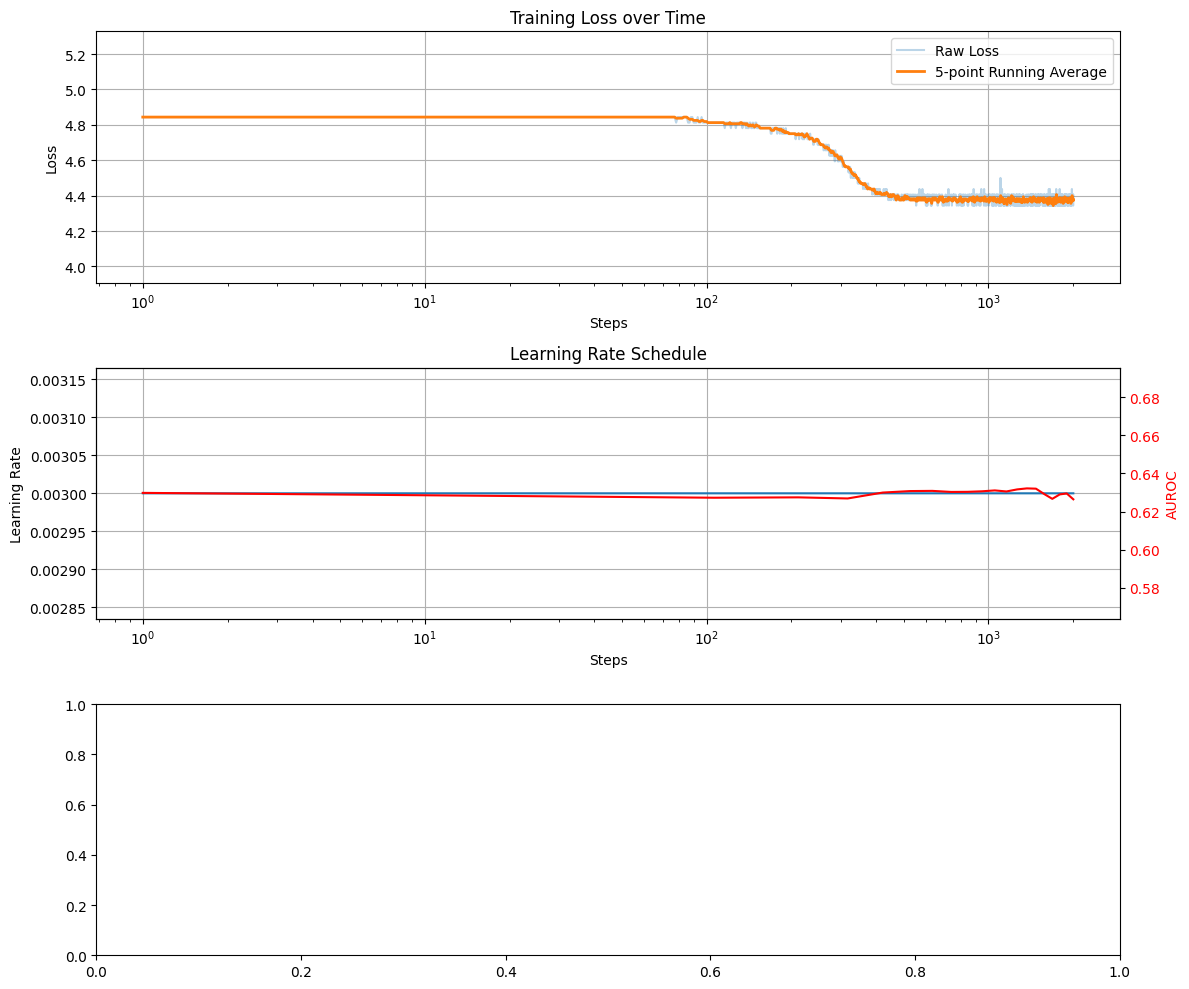

In [88]:
# Extract values from training logs
steps = []
losses = []
lrs = []
stds = []
aurocs = []
accs = []

# Parse the training logs list of dicts
step = 1
for log_dict in training_logs:
    steps.append(step)
    losses.append(log_dict['train_loss'])
    # Extract evaluation metrics if available
    if 'eval_auroc/average_reach_onset' in log_dict:
        aurocs.append(log_dict['eval_auroc/average_reach_onset'])
        accs.append(log_dict['eval_acc/average_reach_onset'])
    # Extract evaluation metrics if available
    if 'eval_auroc/average_onset' in log_dict:
        aurocs.append(log_dict['eval_auroc/average_onset'])
        accs.append(log_dict['eval_acc/average_onset'])
    
    # Get learning rate from last optimizer
    current_lr = optimizers[-1].param_groups[0]['lr']
    lrs.append(current_lr)
    step += 1

# Calculate running average of losses
n_ave = 5
running_avg_losses = []
for i in range(len(losses)):
    if i < n_ave - 1:
        # For first n_ave-1 points, average what we have
        running_avg_losses.append(sum(losses[:i+1]) / (i+1))
    else:
        # For remaining points, take n_ave point average
        running_avg_losses.append(sum(losses[i-n_ave+1:i+1]) / n_ave)

# Create figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

# Plot loss with running average
ax1.semilogx(steps, losses, alpha=0.3, label='Raw Loss')
ax1.semilogx(steps, running_avg_losses, linewidth=2, label=f'{n_ave}-point Running Average')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss over Time')
ax1.grid(True)
ax1.set_ylim(min(losses)*0.9, max(losses)*1.1)
ax1.legend()

# Plot learning rate
ax2.semilogx(steps, lrs)
ax2.set_xlabel('Steps') 
ax2.set_ylabel('Learning Rate')
ax2.set_title('Learning Rate Schedule')
ax2.grid(True)

# If we have evaluation metrics, add them to the plot
if aurocs:
    # Create a twin axis for the AUROC values
    ax4 = ax2.twinx()
    eval_steps = np.linspace(1, len(steps), len(aurocs))  # Only use steps where we have eval metrics
    ax4.semilogx(eval_steps, aurocs, 'r-', label='AUROC')
    ax4.set_ylabel('AUROC', color='r')
    ax4.tick_params(axis='y', labelcolor='r')
    ax4.set_ylim(min(aurocs)*0.9, max(aurocs)*1.1)  # Adjust based on your data

plt.tight_layout()
plt.show()


In [96]:
eval_names = ["onset"]
verbose = True

bins_start_before_word_onset_seconds = 0.5
bins_end_after_word_onset_seconds = 1.0 # 2.5
bin_size_seconds = 0.125

import time

for eval_name in eval_names:
    results_electrode = {}
    for electrode_idx, electrode_label in enumerate(electrode_subset):
        if verbose:
            print(f"Electrode {electrode_label} subject loaded")

        results_electrode[electrode_label] = {
            "time_bins": [],
        }


        # Loop over all time bins
        bin_starts = np.arange(-bins_start_before_word_onset_seconds, bins_end_after_word_onset_seconds, bin_size_seconds)
        bin_ends = bin_starts + bin_size_seconds
        # Add a time bin for the whole window
        # bin_starts = np.append(bin_starts, -bins_start_before_word_onset_seconds)
        # bin_ends = np.append(bin_ends, bins_end_after_word_onset_seconds)
        # # Add a time bin for 1 second after the word onset
        # bin_starts = np.append(bin_starts, 0)
        # bin_ends = np.append(bin_ends, 1)

        for bin_start, bin_end in zip(bin_starts, bin_ends):
            data_idx_from = int((-bin_start)*subject.get_sampling_rate())
            data_idx_to = int((bin_end)*subject.get_sampling_rate())

            bin_results = {
                "time_bin_start": float(bin_start),
                "time_bin_end": float(bin_end),
                "folds": []
            }

            eval_trial_id = trial_id
            evaluation = ModelEvaluation_BTBench(model, inverter, [(subject, eval_trial_id)], eval_names, feature_aggregation_method='concat', 
                                        mean_collapse_factor=128//n_samples_per_bin, 
                                        start_neural_data_before_word_onset=data_idx_from, 
                                        end_neural_data_after_word_onset=data_idx_to, 
                                        eval_electrode_index=electrode_idx)
            eval_results = evaluation.evaluate(return_raw=True)[(eval_name, subject.subject_identifier, eval_trial_id)]
            auroc_list, acc_list = eval_results
            for auroc, acc in zip(auroc_list, acc_list):
                bin_results["folds"].append({
                    "test_accuracy": float(acc),
                    "test_roc_auc": float(auroc)
                })
            
            if verbose: print(f"Electrode {electrode_label} ({electrode_idx+1}/{len(electrode_subset)}), Bin {bin_start}-{bin_end}: Test accuracy: {acc_list}, Test ROC AUC: {auroc_list}")

            if bin_start == -bins_start_before_word_onset_seconds and bin_end == bins_end_after_word_onset_seconds:
                results_electrode[electrode_label]["whole_window"] = bin_results # whole window results
            elif bin_start == 0 and bin_end == 1:
                results_electrode[electrode_label]["one_second_after_onset"] = bin_results # one second after onset results
            else:
                results_electrode[electrode_label]["time_bins"].append(bin_results) # time bin results

    results = {
        "model_name": "Logistic Regression",
        "author": None,
        "description": "Simple linear regression.",
        "organization": "MIT",
        "organization_url": "https://mit.edu",
        "timestamp": time.time(),

        "evaluation_results": {
            f"{subject.subject_identifier}_{trial_id}": {
                "electrode": results_electrode
            }
        },

        "random_seed": 42
    }

    import os, json
    save_dir = "eval_results"
    os.makedirs(save_dir, exist_ok=True) # Create save directory if it doesn't exist
    with open(f"{save_dir}/single_electrode_model_{subject.subject_identifier}_{trial_id}_{eval_name}.json", "w") as f:
        json.dump(results, f, indent=4)
    if verbose:
        print(f"Results saved to {save_dir}/single_electrode_model_{subject.subject_identifier}_{trial_id}_{eval_name}.json")

Electrode F3d1 subject loaded
Electrode F3d1 (1/10), Bin -0.5--0.375: Test accuracy: [0.5247395833333334, 0.4869791666666667, 0.5442708333333334, 0.4778645833333333, 0.5221354166666666], Test ROC AUC: [0.52197265625, 0.4903700086805556, 0.56298828125, 0.4834730360243056, 0.5217488606770834]
Electrode F3d1 (1/10), Bin -0.375--0.25: Test accuracy: [0.5247395833333334, 0.45703125, 0.5169270833333334, 0.5065104166666666, 0.5182291666666666], Test ROC AUC: [0.5348985460069444, 0.4576144748263889, 0.5410630967881944, 0.49081759982638884, 0.5258721245659722]
Electrode F3d1 (1/10), Bin -0.25--0.125: Test accuracy: [0.5091145833333334, 0.4713541666666667, 0.5, 0.48046875, 0.4973958333333333], Test ROC AUC: [0.5169813368055556, 0.4674546983506944, 0.48636203342013895, 0.4774169921875, 0.4858534071180556]
Electrode F3d1 (1/10), Bin -0.125-0.0: Test accuracy: [0.4739583333333333, 0.4674479166666667, 0.5208333333333334, 0.48828125, 0.484375], Test ROC AUC: [0.47100830078125, 0.4644775390625, 0.5094

In [112]:
import random

vocab_size = 10000
vocab = []
for i in range(vocab_size // (window_size // n_samples_per_bin)):
    vocab.append(dataset[random.randint(0, len(dataset)-1)]['data'].reshape(window_size//n_samples_per_bin, n_samples_per_bin))
    vocab[-1] /= 100
vocab = torch.cat(vocab, dim=0)
vocab = vocab.to(device)
vocab_size = len(vocab)
print(vocab.shape)

torch.Size([9920, 4])


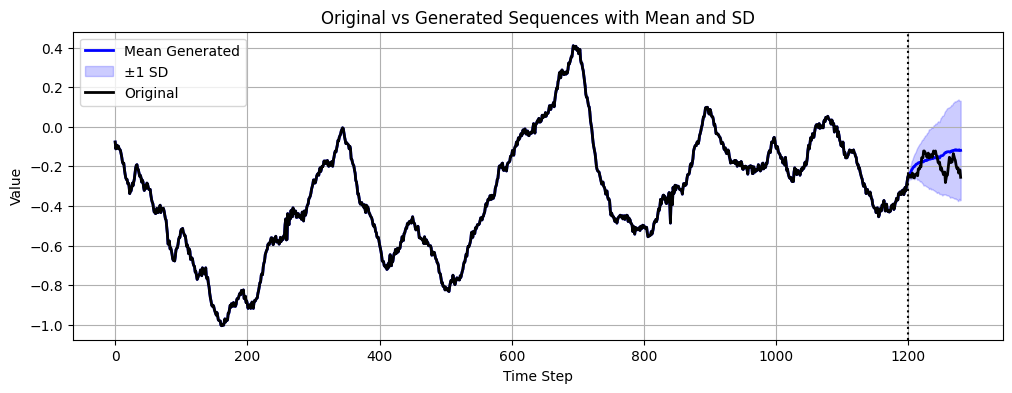

In [116]:
generate_steps = 20
n_generations = 100
batch_index = random.randint(0, len(dataset)-1)

example_seq = dataset[batch_index]['data'].reshape(window_size//n_samples_per_bin, n_samples_per_bin).unsqueeze(0).to(device)
example_seq = example_seq.expand(n_generations, -1, -1)
example_seq = example_seq / 100
continued_seq = model.generate_continuation(example_seq[:, :example_seq.shape[1]-generate_steps], generate_steps, vocab)

example_seq = example_seq[0,:].detach().cpu().numpy().flatten()

import matplotlib.pyplot as plt
import numpy as np

# Plot original and continued sequences
plt.figure(figsize=(12,4))

# Convert continued sequences to numpy array for statistics
continued_seqs_np = np.array([seq.detach().cpu().numpy().flatten() for seq in continued_seq])
mean_seq = np.mean(continued_seqs_np, axis=0)
std_seq = np.std(continued_seqs_np, axis=0)

# Plot individual continued sequences
# for i in range(n_generations):
#     continued_seq_item = continued_seqs_np[i]
#     plt.plot(continued_seq_item, '--', label='Generated' if i == 0 else None, alpha=0.2, color='red', linewidth=1)

# Plot mean and standard deviation
plt.plot(mean_seq, '-', color='blue', label='Mean Generated', linewidth=2)
plt.fill_between(range(len(mean_seq)), mean_seq-std_seq, mean_seq+std_seq, color='blue', alpha=0.2, label='±1 SD')
    
# Plot original sequence
plt.plot(example_seq, label='Original', alpha=1.0, color='k', linewidth=2)

# Add vertical line where generation starts
plt.axvline(x=example_seq.shape[0]-generate_steps*n_samples_per_bin, color='k', linestyle=':')

plt.legend()
plt.title('Original vs Generated Sequences with Mean and SD')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True)
plt.show()
